In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
sns.set(style='whitegrid',palette ='muted')
rcParams['figure.figsize']=14, 8
np.random.seed(1)
tf.random.set_seed(1)
print("TensorFlow Version: ",tf.__version__)

TensorFlow Version:  2.9.2


In [4]:
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [5]:
df.shape


(8192, 2)

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date,y=df.close,mode='lines',name='close'))
fig.update_layout(showlegend=True)
fig.show()

# Data Preprocessing


In [7]:
train_size = int(len(df)*0.8)
test_size = len(df)-train_size
train,test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(6553, 2) (1639, 2)


In [8]:
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
sc = sc.fit(train[['close']])

train['close'] = sc.transform(train[['close']])
test['close'] = sc.transform(test[['close']])

# Train And Test Split

In [9]:
def create_sequences(X,y,time_steps=1):
    Xs,ys =[],[]
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
        
    return np.array(Xs),np.array(ys)
    
    

In [10]:
time_steps=30
X_train,y_train = create_sequences(train[['close']],train.close,time_steps)
X_test,y_test = create_sequences(test[['close']],train.close,time_steps)

In [11]:
print(X_train.shape)

(6523, 30, 1)


# LSTM Autoencoder

In [12]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,RepeatVector,TimeDistributed
model = Sequential([
    LSTM(128,input_shape=(timesteps,num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128,return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
    
])
model.compile(loss='mae',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

# Train The Autoencoder

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
history = model.fit(
        X_train,y_train,epochs=100,
    batch_size=32,validation_split = 0.1,callbacks=[es],shuffle=False
)

Epoch 1/100
184/184 [==============================] - 22s 94ms/step - loss: 0.1711 - accuracy: 0.0000e+00 - val_loss: 0.1696 - val_accuracy: 0.0000e+00
Epoch 2/100
184/184 [==============================] - 19s 105ms/step - loss: 0.1215 - accuracy: 0.0000e+00 - val_loss: 0.0903 - val_accuracy: 0.0000e+00
Epoch 3/100
184/184 [==============================] - 17s 92ms/step - loss: 0.1017 - accuracy: 0.0000e+00 - val_loss: 0.0886 - val_accuracy: 0.0000e+00
Epoch 4/100
184/184 [==============================] - 16s 89ms/step - loss: 0.0955 - accuracy: 0.0000e+00 - val_loss: 0.0825 - val_accuracy: 0.0000e+00
Epoch 5/100
184/184 [==============================] - 17s 90ms/step - loss: 0.0899 - accuracy: 0.0000e+00 - val_loss: 0.0859 - val_accuracy: 0.0000e+00
Epoch 6/100
184/184 [==============================] - 17s 90ms/step - loss: 0.0907 - accuracy: 0.0000e+00 - val_loss: 0.1040 - val_accuracy: 0.0000e+00
Epoch 7/100
184/184 [==============================] - 16s 89ms/step - loss: 0.09

# Plot Metrics and Evaluate The Model

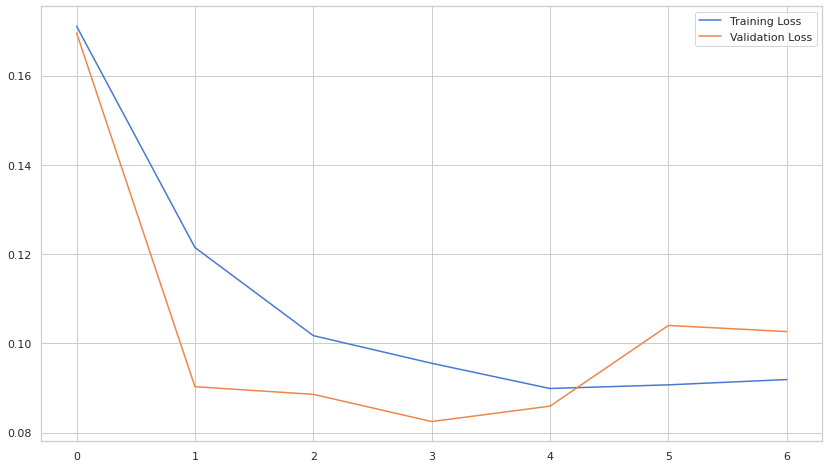

In [15]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [16]:
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred-X_train),axis=1), columns=['Error'])

204/204 [==============================] - 7s 31ms/step


In [17]:
model.evaluate(X_test,y_test)

51/51 [==============================] - 2s 31ms/step - loss: 2.9615 - accuracy: 0.0000e+00


[2.961522340774536, 0.0]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



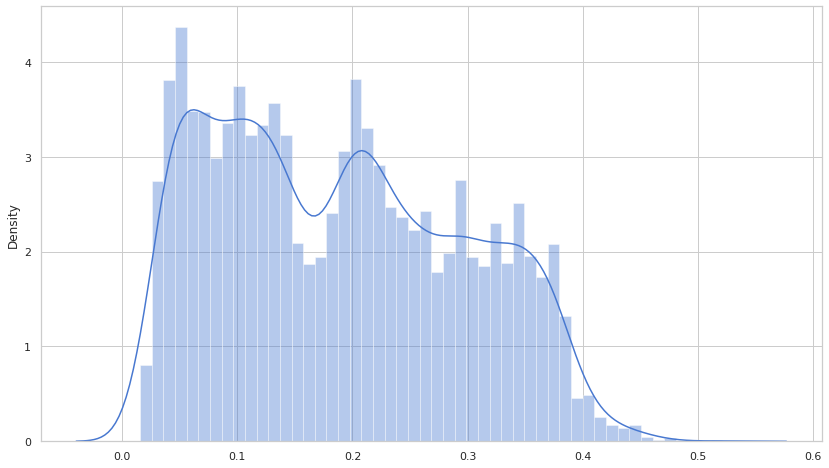

In [18]:
sns.distplot(train_mae_loss,bins=50,kde=True)

In [19]:
threshold =0.65

In [20]:
X_test_pred = model.predict(X_test)

51/51 [==============================] - 2s 31ms/step


In [21]:
test_mae_loss = np.mean(np.abs(X_test_pred-X_test),axis=1)

In [22]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anamoly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [23]:
test_score_df.head()

,date,close,loss,threshold,anamoly
6583,2012-02-08,1.216856,0.100097,0.65,False
6584,2012-02-09,1.221625,0.103086,0.65,False
6585,2012-02-10,1.199313,0.106527,0.65,False
6586,2012-02-13,1.221194,0.113551,0.65,False
6587,2012-02-14,1.218150,0.116644,0.65,False


In [24]:
test_score_df.tail()

,date,close,loss,threshold,anamoly
8187,2018-06-25,4.493228,2.306039,0.65,True
8188,2018-06-26,4.507583,2.314669,0.65,True
8189,2018-06-27,4.451431,2.317872,0.65,True
8190,2018-06-28,4.491406,2.324513,0.65,True
8191,2018-06-29,4.496343,2.324184,0.65,True


In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date,y=test_score_df.loss,mode='lines',name='Test Loss'))
fig.add_trace (go.Scatter(x=test[time_steps:].date,y=test_score_df.threshold,mode='lines',name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()



In [26]:
anamolies = test_score_df[test_score_df.anamoly == True]
anamolies.head()

,date,close,loss,threshold,anamoly
7036,2013-11-26,2.301998,0.653459,0.65,True
7037,2013-11-27,2.312734,0.660097,0.65,True
7038,2013-11-29,2.309331,0.664038,0.65,True
7039,2013-12-02,2.297564,0.668811,0.65,True
7040,2013-12-03,2.283784,0.674849,0.65,True


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date,y=sc.inverse_transform(test[time_steps:].close),mode='lines',name='Close Price'))
fig.add_trace (go.Scatter(x=anamolies.date,y=sc.inverse_transform(anamolies.close),mode='markers',name='Ano'))
fig.update_layout(showlegend=True)
fig.show()


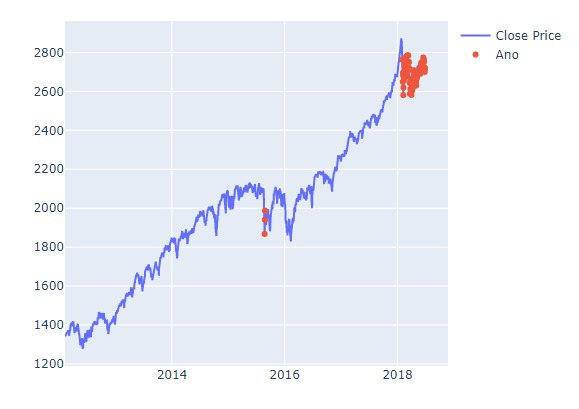